## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import time

In [94]:
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, roc_curve

In [4]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [5]:
path = Path('./data')

In [6]:
train = pd.read_csv(path/'base_features_train.csv')
test = pd.read_csv(path/'base_features_test.csv')

## Data Preparation

In [7]:
def mode_agg(ser):
    mode = ser.mode()
    return None if len(mode) == 0 else mode.iloc[0]

In [8]:
for col in tqdm(['card2', 'card3', 'card4', 'card5', 'card6']):
    combined_data = pd.concat([train[['card1', col]], test[['card1', col]]])
    agg_ser = combined_data.groupby('card1')[col].agg(mode_agg)
    train[col].fillna(train.card1.map(agg_ser), inplace=True)
    test[col].fillna(test.card1.map(agg_ser), inplace=True)
    train[col].fillna(train[col].mode().iloc[0], inplace=True)
    test[col].fillna(test[col].mode().iloc[0], inplace=True)

A Jupyter Widget

In [9]:
train['P_emaildomain'].fillna('Nan', inplace=True)
train['R_emaildomain'].fillna('Nan', inplace=True)
test['P_emaildomain'].fillna('Nan', inplace=True)
test['R_emaildomain'].fillna('Nan', inplace=True)

In [10]:
train.shape, test.shape

((590540, 28), (506691, 27))

## Lightgbm dataset preparation

In [11]:
import lightgbm as lgb

In [12]:
cols = list(train.columns[2:-1])

In [13]:
categorical_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']

In [14]:
for col in categorical_cols:
    col_levels = list(set(list(train[col].unique()) + list(test[col].unique())))
    train[col] = pd.Categorical(train[col], categories=col_levels)
    test[col] = pd.Categorical(test[col], categories=col_levels)

In [15]:
train.sort_values('TransactionDT', inplace=True)

In [235]:
valid_perc = 0.0001

In [236]:
train_check = pd.Series(train.index < (1-valid_perc)*len(train))
valid_check = pd.Series(train.index > (1-valid_perc)*len(train))

In [237]:
trnX, trnY, valX, valY = train[train_check][cols], train[train_check].isFraud.values, train[valid_check][cols], train[valid_check].isFraud.values 

/Users/vinodreddy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [238]:
trn_ds = lgb.Dataset(trnX, trnY)
val_ds = trn_ds.create_valid(valX, valY)

## Model Training

In [239]:
def lr(iter):
    return 0.01*(0.999**iter)

In [240]:

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'false',
    'boosting': 'gbdt',
    'num_leaves': 127,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.9,
    'bagging_freq': 20,
    'verbose': 0,
    'lambda_l2': 0.1,
}

In [241]:
evals_result = {}
model = lgb.train(parameters,
                  trn_ds,
                  valid_sets=val_ds,
                  num_boost_round=200,
                  feature_name=cols,
                  categorical_feature=categorical_cols,
                  evals_result=evals_result,
                  callbacks=[lgb.reset_parameter(lr=lr)])

/Users/vinodreddy/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['P_emaildomain', 'ProductCD', 'R_emaildomain', 'card4', 'card6']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/vinodreddy/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's auc: 0.681034
[2]	valid_0's auc: 0.689655
[3]	valid_0's auc: 0.672414
[4]	valid_0's auc: 0.62931
[5]	valid_0's auc: 0.724138
[6]	valid_0's auc: 0.775862
[7]	valid_0's auc: 0.741379
[8]	valid_0's auc: 0.724138
[9]	valid_0's auc: 0.689655
[10]	valid_0's auc: 0.689655
[11]	valid_0's auc: 0.706897
[12]	valid_0's auc: 0.689655
[13]	valid_0's auc: 0.672414
[14]	valid_0's auc: 0.724138
[15]	valid_0's auc: 0.706897
[16]	valid_0's auc: 0.724138
[17]	valid_0's auc: 0.724138
[18]	valid_0's auc: 0.741379
[19]	valid_0's auc: 0.741379
[20]	valid_0's auc: 0.724138
[21]	valid_0's auc: 0.758621
[22]	valid_0's auc: 0.827586
[23]	valid_0's auc: 0.827586
[24]	valid_0's auc: 0.827586
[25]	valid_0's auc: 0.827586
[26]	valid_0's auc: 0.827586
[27]	valid_0's auc: 0.827586
[28]	valid_0's auc: 0.827586
[29]	valid_0's auc: 0.862069
[30]	valid_0's auc: 0.862069
[31]	valid_0's auc: 0.862069
[32]	valid_0's auc: 0.844828
[33]	valid_0's auc: 0.965517
[34]	valid_0's auc: 0.965517
[35]	valid_0's auc: 0.96

## Analysis

In [159]:
val_preds = model.predict(valX)

In [160]:
print(classification_report(valY, val_preds>0.5))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99    142534
          1       0.78      0.35      0.48      5100

avg / total       0.97      0.97      0.97    147634



Text(0,0.5,'Recall')

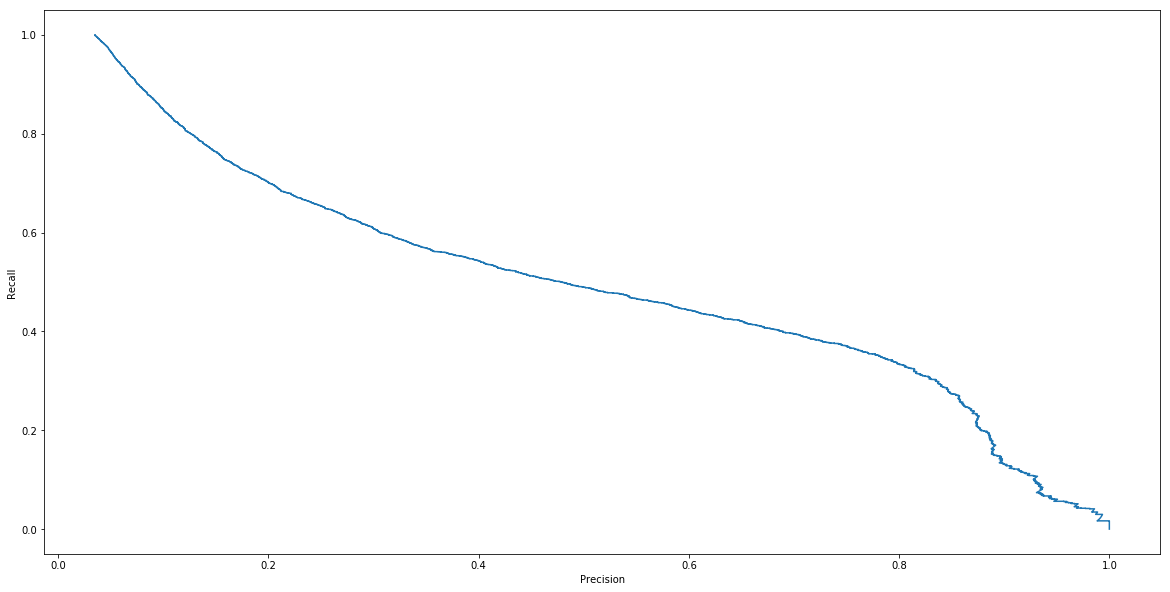

In [161]:
precs, recs, treshs = precision_recall_curve(valY, val_preds)
plt.figure(figsize=(20,10))
plt.plot(precs,recs)
plt.xlabel('Precision')
plt.ylabel('Recall')

Text(0.5,0,'False Positive Rate')

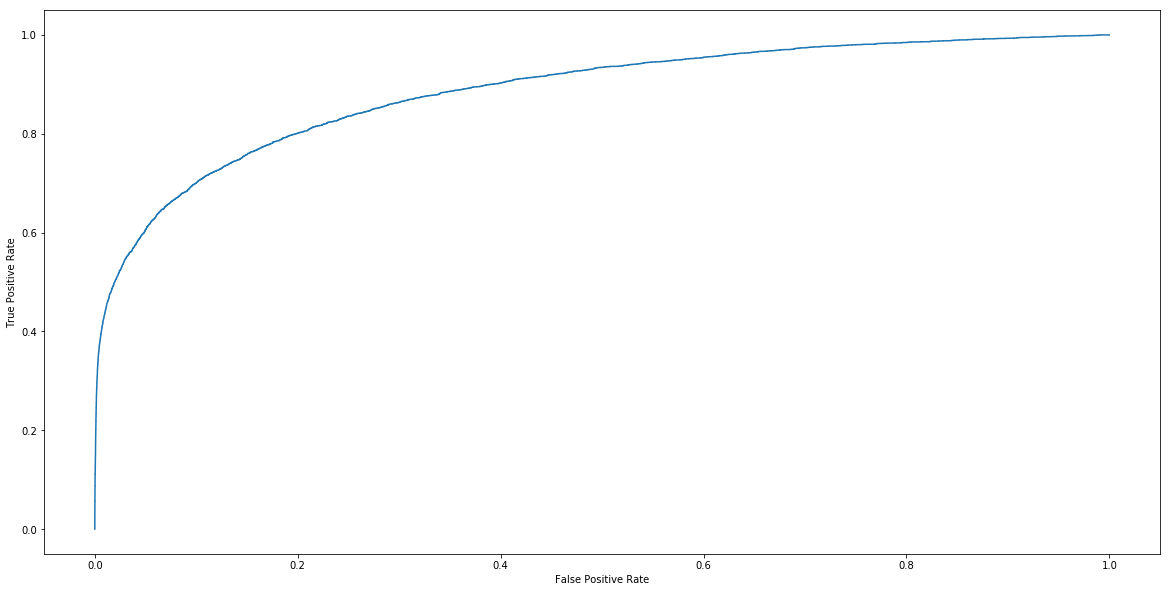

In [162]:
fpr, tpr, threshold = roc_curve(valY, val_preds)
plt.figure(figsize=(20,10))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [163]:
occurred_cards = trnX.card1.value_counts()
valX['Seen'] = valX.card1.map(occurred_cards)
valX['Seen'].fillna(0, inplace=True)

In [173]:
buckets = [-1,0,5,10,50,100,500,1000,2000,4000,10000,20000]
for i in range(1,len(buckets)):
    check = (valX['Seen'] <= buckets[i]) & (valX['Seen'] > buckets[i-1])
    print(buckets[i-1], buckets[i], '%0.2f'%roc_auc_score(valY[check], val_preds[check]), sum(check))

-1 0 0.88 1725
0 5 0.89 5057
5 10 0.89 3708
10 50 0.92 16631
50 100 0.94 10748
100 500 0.90 29185
500 1000 0.88 19269
1000 2000 0.87 18276
2000 4000 0.87 21016
4000 10000 0.81 14984
10000 20000 0.88 7035


## Plots

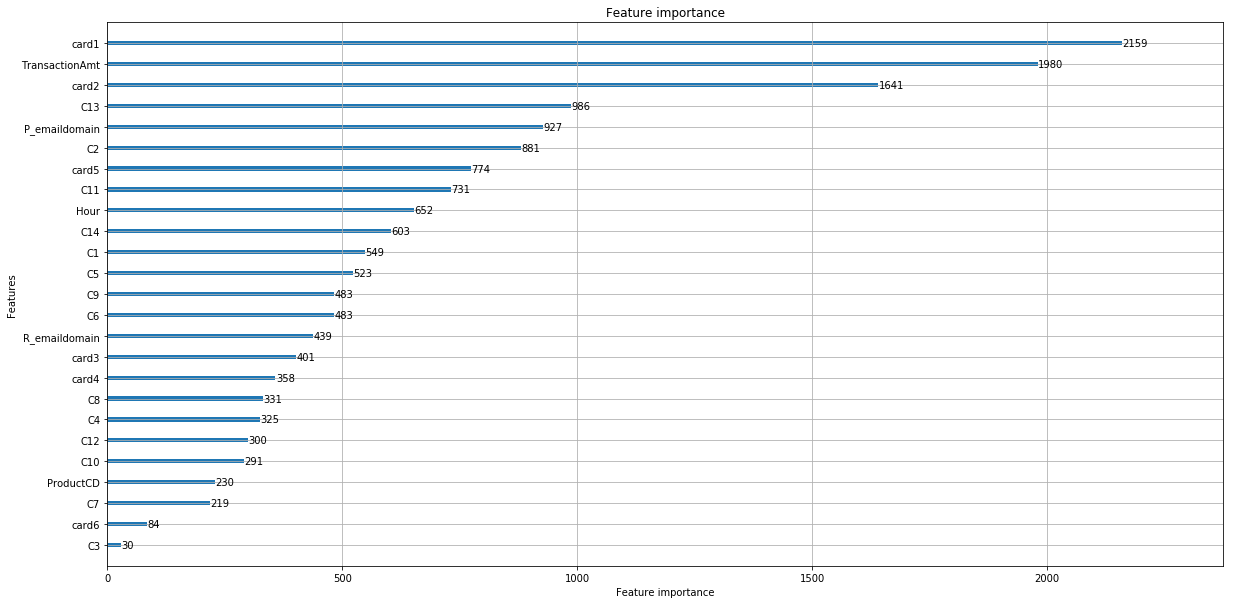

In [96]:
lgb.plot_importance(model, figsize=(20,10))

## Test Predictions

In [242]:
test_preds = model.predict(test[cols])

In [243]:
test_preds

array([0.00078171, 0.00297771, 0.00196999, ..., 0.00653313, 0.00708375,
       0.00525882])

In [244]:
time_part = time.strftime('%d-%m-%y_%H:%M:%S')
pred_df = pd.DataFrame({'TransactionID': test.TransactionID, 'isFraud': test_preds})

In [245]:
pred_df['isFraud'] = pred_df['isFraud'].map(lambda x: int(x*10000)/10000.0)

In [246]:
pred_df.to_csv(path/'Submissions'/f'baseline_submission_{time_part}.csv', header=True, index=False)

In [27]:
len(test_preds)

506691

In [64]:
len(test)

141907

In [65]:
len(train)

144233